# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: CodeChallenge: Autoencoders and occluded Gaussians
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [233]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/4x/pds2gxg17h57rrp30d736s1w0000gn/T/ipykernel_13905/1319117283.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with varying widths and occluding bars

In [234]:
nGauss  = 10000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize two tensor containing images
imagesOcc   = torch.zeros(nGauss,1,imgSize,imgSize)
imagesNoOcc = torch.zeros(nGauss,1,imgSize,imgSize)


for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset 
    
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add the original to the noocc
  imagesNoOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)


  # add a random bar randomly
  i1 = np.random.choice(np.arange(10,imgSize-10))
  i2 = np.random.choice(np.arange(2,6))
#   i1 = 13
#   i2 = 2
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1
  
  # add to the tensor with occlusion
  imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

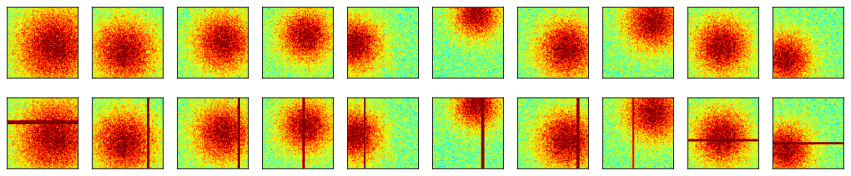

In [235]:
# visualize some images
fig,ax = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  whichpic = np.random.randint(nGauss)
  ax[0,i].imshow(np.squeeze( imagesNoOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
  ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
  
  ax[1,i].imshow(np.squeeze( imagesOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
  ax[1,i].set_xticks([]), ax[1,i].set_yticks([])


plt.show()

# Create the DL model

In [236]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)  
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

 
torch.Size([10, 1, 91, 91])


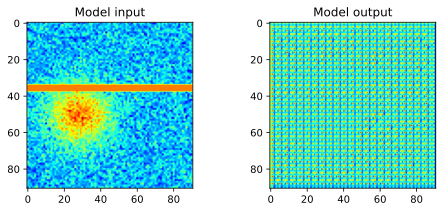

In [237]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(imagesOcc[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(imagesOcc[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

# Create a function that trains the model

In [238]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)

    # get the input (has occlusions) and the target (no occlusions)
    X = imagesOcc[pics2use,:,:,:]
    Y = imagesNoOcc[pics2use,:,:,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,Y)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [239]:
# test the model on a bit of data
losses,net = function2trainTheModel()

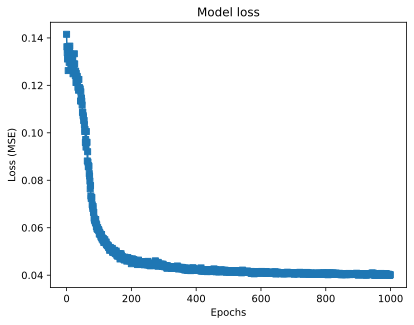

In [240]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

plt.show()

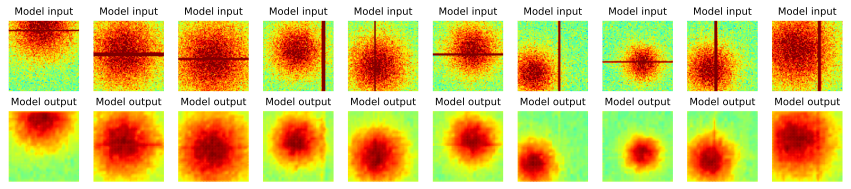

In [241]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imagesOcc[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  
  G = torch.squeeze( X[i,0,:,:] ).detach()
  O = torch.squeeze( yHat[i,0,:,:] ).detach()
  
  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input',fontsize=10)

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output',fontsize=10)

plt.show()

# Additional explorations

In [242]:
# 1) The network does OK but there are still residual occlusion artifacts. Perhaps there weren't enough training examples?
#    If you would increase nGauss from 1000 to 10000, would that mean that the model trains on 10x as many examples? 
#    (Hint: the answer is No, but you need to figure out why!) How can you adapt the model so that it trains on more
#    unique sample images?
# MY COMMENT: No, because lots of images are very closely clustered together making them indistinguishable. We can
# move about centers of images more and opt for larger images to allow for more room for movement of centers
# 2) The bars appear in a random location for each image. Would the network still learn to remove the occlusions if the
#    bars appeared in the exact same location with the same thickness? Change the stimulus generation code to implement
#    this. You can still keep the randomization to horizontal or vertical, but remove the random selection of thickness
#    and location.
# MY COMMENT: YES